In [30]:
import cv2 as cv

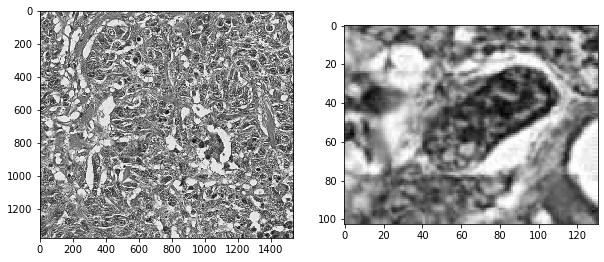

In [31]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

img1 = cv.imread("A03_00Bd.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("A03_00Bdcropped1.jpeg", cv.IMREAD_GRAYSCALE)


if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

In [32]:
detector = cv.ORB_create(10000)
kpts1 = detector.detect(img1, None)
kpts2 = detector.detect(img2, None)

In [33]:
# descriptor = cv.ORB_create()
descriptor = cv.xfeatures2d.BEBLID_create(0.75)
kpts1, desc1 = descriptor.compute(img1, kpts1)
kpts2, desc2 = descriptor.compute(img2, kpts2)

In [34]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(m)
        matched2.append(m)

In [35]:
matched1

[<DMatch 000002747F27AEB0>,
 <DMatch 000002747F2831D0>,
 <DMatch 000002747F283DB0>,
 <DMatch 000002747F28EB50>,
 <DMatch 000002747F2908B0>,
 <DMatch 000002747F29E370>,
 <DMatch 000002747F2B0130>,
 <DMatch 000002747F2B0EF0>,
 <DMatch 000002747F2B95F0>,
 <DMatch 000002747F2B9670>,
 <DMatch 000002747F2BB870>,
 <DMatch 000002747F2D4950>,
 <DMatch 000002747F2E31F0>,
 <DMatch 000002747F3205F0>,
 <DMatch 000002747F320AF0>,
 <DMatch 000002740399F250>,
 <DMatch 00000274039E6B90>,
 <DMatch 00000274039E6C50>,
 <DMatch 00000274039E8690>,
 <DMatch 00000274039E8910>,
 <DMatch 00000274039E8990>,
 <DMatch 00000274039EDE90>,
 <DMatch 00000274039FAF50>,
 <DMatch 0000027403A05890>,
 <DMatch 0000027403A07190>,
 <DMatch 0000027403A15B50>,
 <DMatch 0000027403A15DD0>,
 <DMatch 0000027403A17E10>,
 <DMatch 0000027403A1E790>,
 <DMatch 00000274039A04D0>,
 <DMatch 00000274039A2C10>,
 <DMatch 00000274039A56D0>,
 <DMatch 00000274039AEC90>,
 <DMatch 00000274039B2B10>,
 <DMatch 00000274039B96D0>,
 <DMatch 00000274039

In [36]:
MIN_MATCH_COUNT = 10

In [37]:
if len(matched1)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpts1[m.queryIdx].pt for m in matched1 ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in matched2 ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)

In [38]:
M

array([[-9.02307806e-03, -2.40762111e-02,  3.91584681e+01],
       [-1.61485817e-02, -4.25705429e-02,  6.92062664e+01],
       [-2.31829384e-04, -6.15803477e-04,  1.00000000e+00]])

In [39]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

In [40]:
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5  # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    # Create the homogeneous point
    col = np.ones((3, 1), dtype=np.float64)
    col[0:2, 0] = m.pt
    # Project from image 1 to image 2
    col = np.dot(M, col)
    col /= col[2, 0]
    # Calculate euclidean distance
    dist = sqrt(pow(col[0, 0] - matched2[i].pt[0], 2) + \
                pow(col[1, 0] - matched2[i].pt[1], 2))
    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])

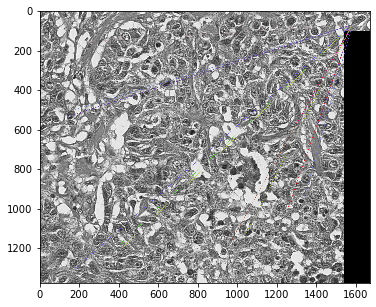

In [41]:
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
plt.figure(figsize=(15, 5))
plt.imshow(res)

In [47]:
backtorgb = cv.cvtColor(res,cv.CV_GRAY2RGB)

AttributeError: module 'cv2.cv2' has no attribute 'CV_GRAY2RGB'

In [42]:
inlier_ratio = len(inliers1) / float(len(matched1))
print('Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(kpts1))
print('# Keypoints 2:                        \t', len(kpts2))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)

Matching Results
*******************************
# Keypoints 1:                        	 10000
# Keypoints 2:                        	 170
# Matches:                            	 59
# Inliers:                            	 14
# Inliers Ratio:                      	 0.23728813559322035
